# Delta‑Only Hedging (SPX) — Using OptionMetrics OMunderlying.csv for Spot

This notebook mirrors the delta–vega structure but performs **delta-only hedging**.
- Load option data (`options_dataset.parquet`).
- Load OMunderlying.csv spot levels instead of Yahoo prices.
- Use SPX close prices as the underlying for mark-to-market.
- Daily delta‑hedge using the underlying only (no vega hedge).
- Self‑financing accounting, no transaction costs on spot.
- 21‑trading‑day non‑overlapping windows from 2021‑01‑01 onward.


In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

TRADING_DAYS_PER_MONTH = 21
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

pd.set_option('display.max_columns', 100)

In [2]:
df_1m = pd.read_csv('../FilteredDataset.csv', index_col=0)
df_1m['date'] = pd.to_datetime(df_1m['date'])
df_1m['exdate'] = pd.to_datetime(df_1m['exdate'])
print(f"\nFinal filtered dataset: {len(df_1m)} rows")
df_1m.head(10)


Final filtered dataset: 28073947 rows


,date,exdate,cp_flag,strike_price,spot,moneyness,dte,mid,best_bid,best_offer,volume,open_interest,delta,vega,impl_volatility,spread,rel_spread
0,2000-01-03,2000-01-22,P,1275.0,1455.22,0.876156,19,2.0000,1.750,2.250,585,23785,-0.041295,28.57753,0.358787,0.500,0.250000
1,2000-01-03,2000-01-22,P,1300.0,1455.22,0.893336,19,2.6250,2.250,3.000,3572,26621,-0.055490,36.20153,0.334738,0.750,0.285714
2,2000-01-03,2000-01-22,P,1325.0,1455.22,0.910515,19,3.8125,3.500,4.125,1406,30757,-0.079749,47.92918,0.317378,0.625,0.163934
3,2000-01-03,2000-01-22,C,1325.0,1455.22,0.910515,19,134.5000,133.500,135.500,315,29529,0.983012,13.61578,0.207545,2.000,0.014870
4,2000-01-03,2000-01-22,C,1350.0,1455.22,0.927695,19,111.1250,110.125,112.125,112,20500,0.939732,38.63064,0.229941,2.000,0.017998
5,2000-01-03,2000-01-22,P,1350.0,1455.22,0.927695,19,5.1875,4.875,5.500,819,24413,-0.109956,60.74824,0.294041,0.625,0.120482
6,2000-01-03,2000-01-22,C,1375.0,1455.22,0.944874,19,88.5000,87.500,89.500,6,7885,0.884385,62.96457,0.229135,2.000,0.022599
7,2000-01-03,2000-01-22,P,1375.0,1455.22,0.944874,19,6.9375,6.750,7.125,2633,18270,-0.150684,75.57642,0.267472,0.375,0.054054
8,2000-01-03,2000-01-22,C,1380.0,1455.22,0.948310,19,84.0000,83.000,85.000,4,13,0.872528,67.43791,0.226489,2.000,0.023810
9,2000-01-03,2000-01-22,P,1380.0,1455.22,0.948310,19,8.1250,7.625,8.625,69,1458,-0.168821,81.41239,0.271506,1.000,0.123077


In [3]:
def choose_strike_for_m0(spot0: float, m0: float, strikes: np.ndarray) -> float:
    target = m0 * spot0
    return float(strikes[np.abs(strikes-target).argmin()])

def pick_one(day_df, strike, cp_flag):
    sub = day_df[(day_df['strike_price']==strike)&(day_df['cp_flag']==cp_flag)].copy()
    if sub.empty: return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer']>=sub['best_bid']]
    if sub.empty: return None
    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]  # ← quality filters
    if sub.empty:
        print(f"[pick_one] No clean candidate after filters for cp={cp_flag}, K={strike}")
        return None

    # Different sorting:
    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def fetch_next_row(next_df, strike, cp_flag):
    sub = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[next fetch] MISSING next-day row for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[next fetch] All next-day candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[next fetch] No clean next-day candidate for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

In [4]:
# === 4) One‑day step (delta‑only) ===
def one_day_step(df_all, d, d_next, K_straddle, phi_under_prev, use_costs=False):
    day = df_all[df_all['date']==d]; day_next = df_all[df_all['date']==d_next]
    if day.empty or day_next.empty: return None
    rowC = pick_one(day,K_straddle,'C')
    rowP = pick_one(day,K_straddle,'P')
    if (rowC is None) or (rowP is None): return None
    rowC_n = fetch_next_row(day_next,K_straddle,'C')
    rowP_n = fetch_next_row(day_next,K_straddle,'P')
    if (rowC_n is None) or (rowP_n is None): return None

    spot_t, spot_t1 = rowC['spot'], rowC_n['spot']
    psiC, psiP = 1.0, 1.0
    V_t = psiC*rowC['mid'] + psiP*rowP['mid']
    dV_t = psiC*rowC['delta'] + psiP*rowP['delta']
    phi_under = dV_t
    pnl_under = phi_under*(spot_t1-spot_t)
    cost_under = 0.0
    pnl_unhedged = psiC*(rowC_n['mid']-rowC['mid']) + psiP*(rowP_n['mid']-rowP['mid'])
    return dict(date=d, V_t=V_t, phi_under=phi_under,
                pnl_under=pnl_under, pnl_unhedged=pnl_unhedged, cost_under=cost_under)

In [5]:
# === 5) Run one 21‑day window ===
def get_window_dates(df_all,start_idx):
    dates=np.sort(df_all['date'].unique())
    if start_idx+TRADING_DAYS_PER_MONTH>=len(dates): return None
    return list(dates[start_idx:start_idx+TRADING_DAYS_PER_MONTH+1])

def run_single_window(df_all,start_idx,m0, use_costs=False):
    days=get_window_dates(df_all,start_idx)
    if days is None: return None
    d0=days[0]; day0=df_all[df_all['date']==d0]
    spot0=float(day0['spot'].iloc[0]); strikes=np.sort(day0['strike_price'].unique())
    K_straddle=choose_strike_for_m0(spot0,m0,strikes)
    phi_prev=0.0; recs=[]; V0=None; Pi_t=None
    for t in range(len(days)-1):
        step=one_day_step(df_all,days[t],days[t+1],K_straddle,phi_prev, use_costs=use_costs)
        if step is None: return None
        
        if V0 is None: V0=step['V_t']; Pi_t=V0
        Pi_t1=Pi_t+step['pnl_under'] - step['cost_under'] # self-financing update
        step['Pi_t']=Pi_t; step['Pi_t1']=Pi_t1
        recs.append(step); phi_prev=step['phi_under']; Pi_t=Pi_t1
    last_day, fin_day = days[-2], days[-1]
    dL=df_all[df_all['date']==last_day]; dF=df_all[df_all['date']==fin_day]
    rC=pick_one(dL,K_straddle,'C'); rC_f=fetch_next_row(dF,K_straddle,'C')
    rP=pick_one(dL,K_straddle,'P'); rP_f=fetch_next_row(dF,K_straddle,'P')
    if (rC is None) or (rC_f is None) or (rP is None) or (rP_f is None): return None
    V_T=float(rC_f['mid']+rP_f['mid']); Pi_T=float(recs[-1]['Pi_t1'])
    return dict(summary=dict(start=days[0],end=days[-1],m0=m0,
                             K_straddle=K_straddle,
                             V0=recs[0]['V_t'],
                             V_T=V_T,Pi_T=Pi_T,
                             tracking_error=V_T-Pi_T,
                             pnl_unhedged=V_T-recs[0]['V_t'],
                             pnl_hedged=Pi_T-recs[0]['V_t']),
                timeline=pd.DataFrame(recs))

In [6]:
# === 6) Multi‑window loop ===
def run_experiment(df_all,m0_list,max_windows=52):
    dts=np.sort(df_all['date'].unique())
    starts=list(range(0,len(dts)-TRADING_DAYS_PER_MONTH-1,TRADING_DAYS_PER_MONTH))
    starts=starts[:max_windows]; results=[]
    for m in m0_list:
        print(f"\n=== Running m0={m} ===")
        for si in starts:
            print(f"--- Window starting at index {si/21} ({pd.Timestamp(dts[si]).date()}) ---")
            out=run_single_window(df_all,si,m, use_costs=True)
            if out is not None: results.append(out['summary'])
    return pd.DataFrame(results)

In [8]:
start_backtest = pd.Timestamp("2020-01-01")
df_1m_bt = df_1m[df_1m['date'] >= start_backtest].copy().sort_values('date')

In [9]:
# === 7) Backtest setup ===

m0_list=[0.75,0.8,0.9,1.1]
results_delta=run_experiment(df_1m_bt,m0_list,max_windows=52)
results_delta.head(10)
res = results_delta.sort_values('end').reset_index(drop=True).copy()


=== Running m0=0.75 ===
--- Window starting at index 0.0 (2020-01-02) ---
[next fetch] MISSING next-day row for cp=C, K=2445.0
--- Window starting at index 1.0 (2020-02-03) ---
--- Window starting at index 2.0 (2020-03-04) ---
--- Window starting at index 3.0 (2020-04-02) ---
[next fetch] MISSING next-day row for cp=P, K=1895.0
--- Window starting at index 4.0 (2020-05-04) ---
--- Window starting at index 5.0 (2020-06-03) ---
--- Window starting at index 6.0 (2020-07-02) ---
--- Window starting at index 7.0 (2020-08-03) ---
--- Window starting at index 8.0 (2020-09-01) ---
--- Window starting at index 9.0 (2020-10-01) ---
--- Window starting at index 10.0 (2020-10-30) ---
--- Window starting at index 11.0 (2020-12-01) ---
--- Window starting at index 12.0 (2020-12-31) ---
--- Window starting at index 13.0 (2021-02-02) ---
--- Window starting at index 14.0 (2021-03-04) ---
--- Window starting at index 15.0 (2021-04-05) ---
--- Window starting at index 16.0 (2021-05-04) ---
--- Window s

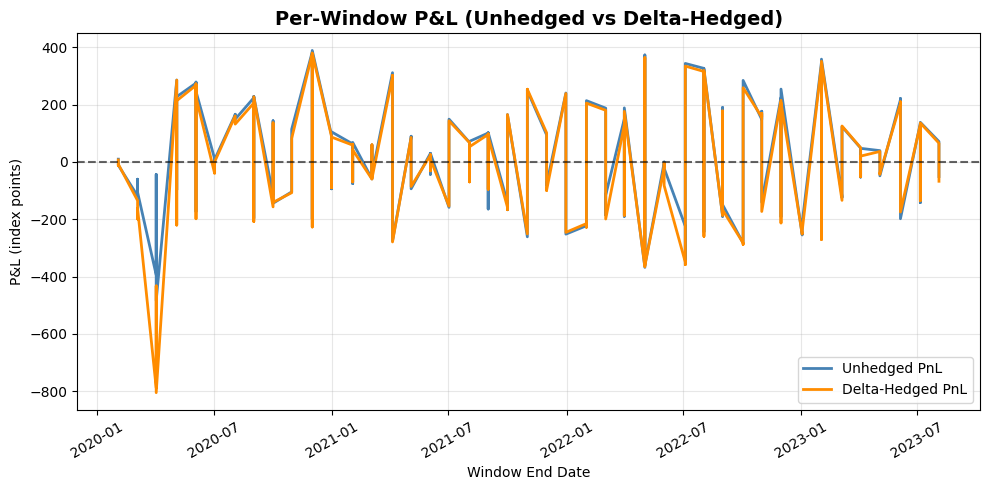

In [10]:
plt.figure(figsize=(10,5))
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', color='steelblue', linewidth=2)
plt.plot(res['end'], res['pnl_hedged'], label='Delta-Hedged PnL', color='darkorange', linewidth=2)
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per‑Window P&L (Unhedged vs Delta‑Hedged)', fontsize=14, fontweight='bold')
plt.xlabel('Window End Date')
plt.ylabel('P&L (index points)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

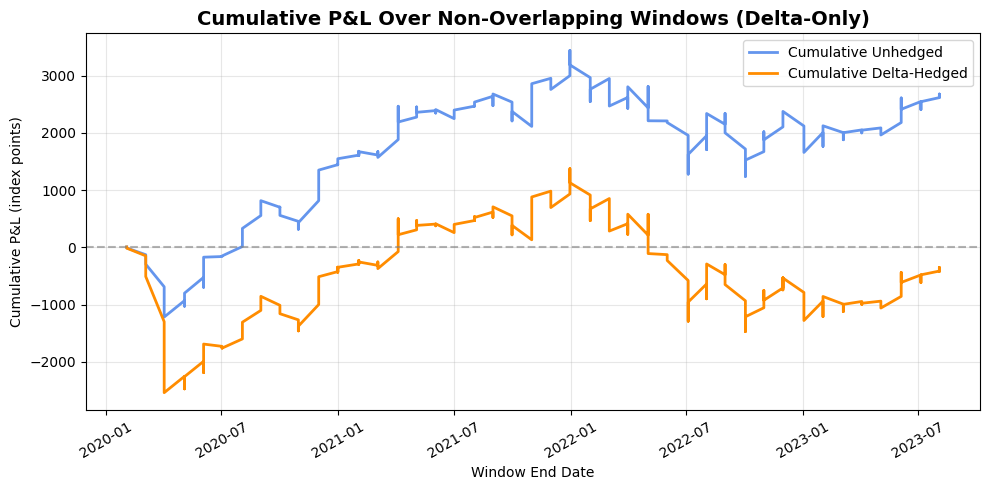

In [11]:
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged']   = res['pnl_hedged'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', color='cornflowerblue', linewidth=2)
plt.plot(res['end'], res['cum_hedged'], label='Cumulative Delta-Hedged', color='darkorange', linewidth=2)
plt.axhline(0, linestyle='--', color='gray', alpha=0.6)
plt.title('Cumulative P&L Over Non‑Overlapping Windows (Delta‑Only)', fontsize=14, fontweight='bold')
plt.xlabel('Window End Date')
plt.ylabel('Cumulative P&L (index points)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

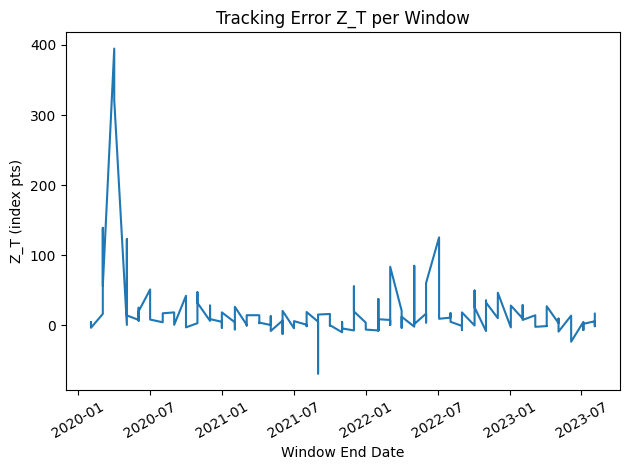

In [12]:
plt.figure()
plt.plot(res['end'], res['tracking_error'])
plt.title('Tracking Error Z_T per Window'); plt.xlabel('Window End Date'); plt.ylabel('Z_T (index pts)')
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

<Figure size 1000x500 with 0 Axes>

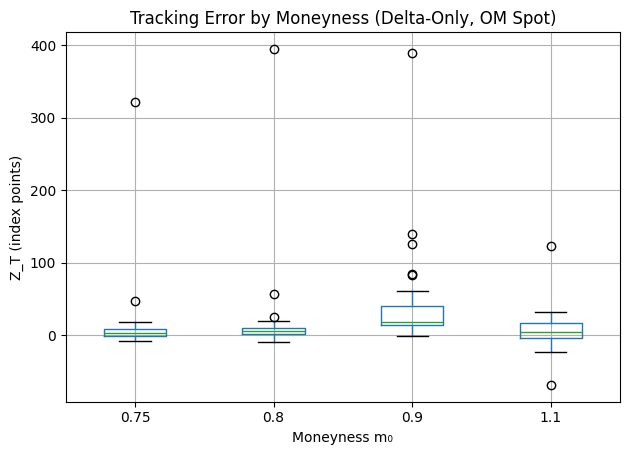

In [13]:
# === 8) Boxplot for tracking error ===
plt.figure(figsize=(10,5))
results_delta.boxplot(column='tracking_error',by='m0')
plt.title('Tracking Error by Moneyness (Delta‑Only, OM Spot)')
plt.suptitle(''); plt.xlabel('Moneyness m₀'); plt.ylabel('Z_T (index points)')
plt.tight_layout(); plt.show()

In [14]:
summary_df = res.groupby('m0')['tracking_error'].agg(
    mean='mean',
    median='median',
    std='std',
    VaR_5pct=lambda x: x.quantile(0.05),
    VaR_1pct=lambda x: x.quantile(0.01)
).round(3)

print("Tracking Error Summary (Delta‑Only Hedging)")
display(summary_df)

Tracking Error Summary (Delta‑Only Hedging)


,mean,median,std,VaR_5pct,VaR_1pct
m0,,,,,
0.75,13.274,3.010,53.676,-4.602,-8.087
0.80,15.726,5.062,61.597,-6.509,-8.433
0.90,37.942,18.320,62.745,4.584,-0.434
1.10,7.406,3.735,26.100,-13.450,-51.665


In [15]:
# save to csv
results_delta.to_csv('results_delta.csv', index=False)
print("Delta results saved to results_delta.csv")

Delta results saved to results_delta.csv
